### Описание данных  

Файл содержит [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку
midprice - цена актива  
signal - сигнал, полученный от модели, которая оценивает изменение цены 

#### Цена актива
На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = \frac{(askbest(t) + bidbest(t))}{2} $$  

С помощью сигнала от модели определим прогноз цены в будущем:  
$$midprice(t + 1) = midprice(t) + signal(t)$$

### Считывание данных

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *
from sklearn.linear_model import LinearRegression


In [92]:
backtest_df = pd.read_parquet('test_quant.parquet')

In [93]:
backtest_df.tail()



,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
index,,,,,,,
2019-09-18 06:08:46.227,"[380.02, 380.03, 380.04, 380.05, 380.07]","[4.57266, 54.3976, 0.50151, 0.48145, 0.50151]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.031, 1.45021, 10.41323]",380.015,-0.010,-0.000562
2019-09-18 06:08:46.427,"[380.02, 380.03, 380.04, 380.05, 380.06]","[9.0, 58.97026, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.002318
2019-09-18 06:08:46.527,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.001896
2019-09-18 06:08:46.627,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.72768, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.031, 0.02895, 2.41323]",380.015,-0.010,-0.002480
2019-09-18 06:08:46.827,"[380.01, 380.02, 380.03, 380.05, 380.06]","[66.5, 4.57266, 54.3976, 0.24623, 0.13]","[380.0, 379.99, 379.98, 379.96, 379.94]","[0.66331, 0.031, 0.02895, 2.41323, 5.73953]",380.005,-0.055,-0.005292


count    787690.000000
mean          0.000097
std           0.036378
min          -0.675000
25%          -0.005000
50%           0.000000
75%           0.005000
max           0.660000
Name: target, dtype: float64


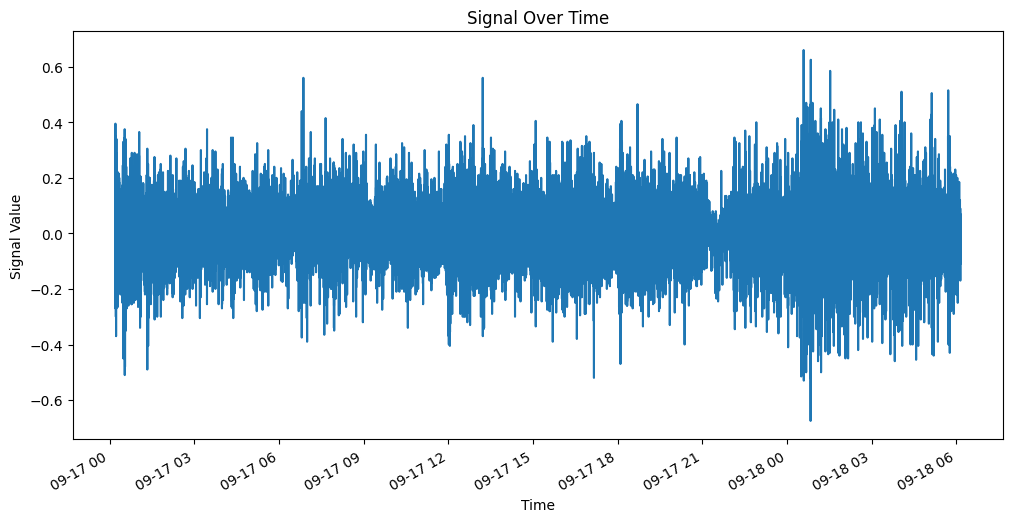

In [94]:
print(backtest_df['target'].describe())
plt.figure(figsize=(12, 6))
backtest_df['target'].plot()
plt.title("Signal Over Time")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.show()

In [95]:
def compute_trend(series):
    """
    Compute the linear regression trend for a time series.
    """
    # Create an index for time (here just the row index for simplicity)
    X = np.array(range(len(series))).reshape(-1, 1)  # Time index
    y = series.values  # The actual values of the time series
    
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)  # Predicted trend
    return trend, model.coef_[0]  # Return trend and slope (coefficient)


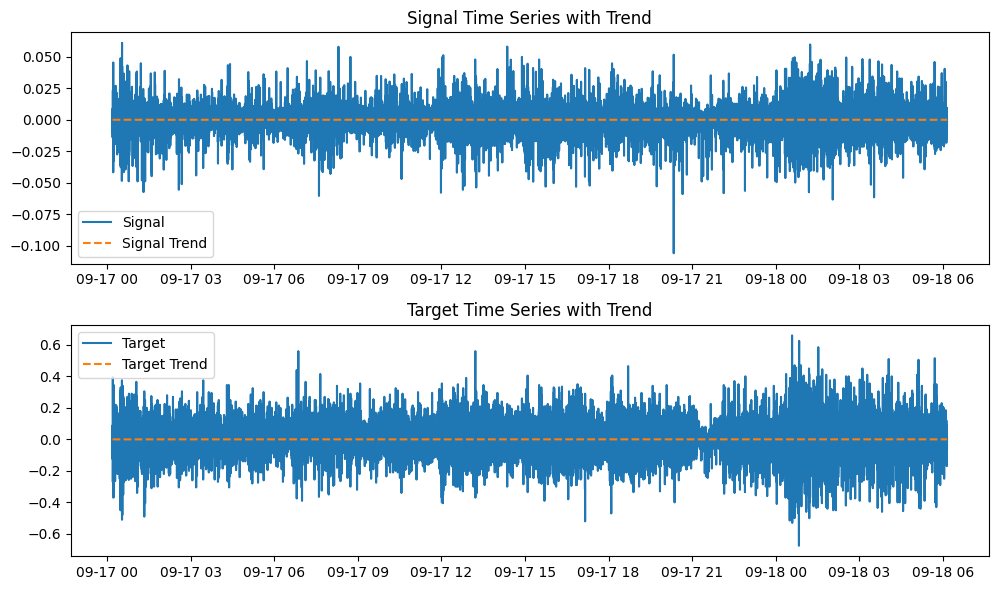

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming backtest_df contains your original data, including 'timestamp', 'signal', and 'target'
signal_trend, signal_slope = compute_trend(backtest_df['signal'])
target_trend, target_slope = compute_trend(backtest_df['target'])

# Create a new DataFrame by combining backtest_df and the trends
df = backtest_df.copy()

# Add the trend columns to the dataframe
df['signal_trend'] = signal_trend
df['target_trend'] = target_trend

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Signal with its Trend
plt.subplot(2, 1, 1)
plt.plot( df['signal'], label='Signal')
plt.plot( df['signal_trend'], label='Signal Trend', linestyle='--')
plt.legend()
plt.title('Signal Time Series with Trend')

# Plot Target with its Trend
plt.subplot(2, 1, 2)
plt.plot(df['target'], label='Target')
plt.plot( df['target_trend'], label='Target Trend', linestyle='--')
plt.legend()
plt.title('Target Time Series with Trend')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [97]:
backtest_df.shape

(787690, 7)

### Пример стратегии

#### Принцип работы стратегии  
Стратегия - это некоторый набор условий, по которому в каждый момент времени принимается решение, нужно ли сейчас покупать, продавать, либо ничего не делать.  
Результат работы стратегии - необходимый объем сделки (```order_size```). Если значение объема положительное - совершается покупка (buy). Если отрицательное - продажа (sell). Если 0 - ничего не происходит (hold).  

```order_size = 1``` — сделать покупку объемом 1  
```order_size = -1``` — сделать продажу объемом 1  

Совершение сделки на покупку изменяет текущую позицию (```current_position```) в положительную сторону, на продажу - в отрицательную.  
Текущая позиция отражает кумулятивную сумму купленных и проданных объемов.  
Пример изменения текущей позиции:  

```1. order_size = 0 -> current_position = 0```  
```2. order_size = 1 -> current_position = 1  # открытие позиции```  
```3. order_size = -1 -> current_position = 0  # закрытие позиции```  
  
Максимальная позиция (```max_position```) - наибольшее абсолютное значение текущей позиции. Если текущая позиция равна максимальной, нельзя совершать сделки в ту же сторону.  
При ```max_position = 1```:   

```1. order_size = 0 -> current_position = 0```  
```2. order_size = -1 -> current_position = -1```  
```3. order_size = -1 -> current_position = -1  # нельзя превысить max_position```   
```4. order_size = 1 -> current_position = 0```   

In [114]:
def strategy_trading(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    treshold = 0.01
    min_treshold = 0.001
    commission = 0.0001

    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    ask_best = min(ask_rate)
    bid_best = max(bid_rate)
    spread = bid_best - ask_best
    mid_price = (ask_best + bid_best) / 2

    ask_liquidity = sum(ask_amount)
    bid_liquidity = sum(bid_amount)

    # Initialize previous signals storage
    if 'previous_signals' not in storage:
        storage['previous_signals'] = []
    storage['previous_signals'].append(signal)
    
    # Keep track of the last 200 signals +
    if len(storage['previous_signals']) > 50:
        storage['previous_signals'].pop(0)
    order_size = 0

    # Smoothed signal is the average of previous signals+
    smoothed_signal = sum(storage['previous_signals']) / len(storage['previous_signals'])
        
    # If smoothed signal is greater than commission threshold, evaluate conditions
    if smoothed_signal > commission:
        if spread > treshold and signal > 0:
            order_size = min(trade_size*signal, max_position - current_position)  # Buy signal
        elif abs(spread) > min_treshold  and signal > 0:
            order_size = min(trade_size * smoothed_signal, max_position - current_position)  # Buy signal with scaling based on smoothed signal
        elif abs(spread) > min_treshold and signal < 0:
            order_size = -min(trade_size * abs(smoothed_signal), max_position + current_position)  # Sell signal
        elif spread < treshold and signal < 0:
            order_size = -min(trade_size*abs(signal), max_position + current_position)  # Buy signal
    # No action if the smoothed signal does not meet commission threshold
    else:
        order_size = 0


    # Store the previous signal for next iteration
    storage['prev_signal'] = signal
    
    return order_size


In [99]:

def strategy_trading_3(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    min_threshold = 0.01
    spread_threshold = 0.02
    commission = 0.0001
    volatility_threshold = 0.05
    
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    ask_best = min(ask_rate)
    bid_best = max(bid_rate)
    spread = ask_best - bid_best
    mid_price = (ask_best + bid_best) / 2

    # Weighted average of price
    wap = calc_wap(ask_amount, bid_amount, ask_rate, bid_rate)
    
    ask_liquidity = sum(ask_amount)
    bid_liquidity = sum(bid_amount)
    
    # Initialize previous waps storage if not already done
    storage.setdefault('previous_wap', [])
    storage['previous_wap'].append(wap)
    
    # Initialize log returns storage if not already done
    storage.setdefault('log_return', [])
    if len(storage['previous_wap']) > 1:
        storage['log_return'].append(np.log(wap / storage['previous_wap'][-2]))
    
    # Initialize previous signals storage if not already done
    storage.setdefault('previous_signals', [])
    storage['previous_signals'].append(signal)
        
    # Keep track of the last 50 signals
    if len(storage['previous_signals']) > 50:
        storage['previous_signals'].pop(0)
    
    # Keep track of the last 100 log returns and 5 waps
    if len(storage['log_return']) > 100:
        storage['log_return'].pop(0)
    if len(storage['previous_wap']) > 5:
        storage['previous_wap'].pop(0)

    # Calculate smoothed log return using an exponentially weighted moving average (EMA)
    log_return_series = pd.Series(storage['log_return'])
    storage['smoothed_log_return'] = log_return_series.ewm(span=50, adjust=False).mean()

    # Calculate volatility using a rolling window for standard deviation
    rolling_volatility = log_return_series.rolling(window=100).std()
    
    # Store the last value of volatility for future reference
    storage['volatility'] = rolling_volatility.iloc[-1]  # Use the last value in the series

    # Calculate upper and lower thresholds based on smoothed return and volatility
    storage['upper_threshold'] = storage['smoothed_log_return'] + 1.5 * storage['volatility']
    storage['lower_threshold'] = storage['smoothed_log_return'] - 1.5 * storage['volatility']

    # Smoothed signal: average of previous signals (or use weighted average)
    smoothed_signal = np.mean(storage['previous_signals'])

    # No trade if the smoothed signal is too small relative to commission
    if abs(smoothed_signal) <= commission:
        return 0  # No trade if the signal is too small relative to commission

    # Ensure volatility data exists and is a valid scalar
    last_volatility = storage['volatility'] if storage['volatility'] is not None else None

    # Handle volatility conditions
    order_size = 0
    
    # Check if last_volatility is valid and compare it to the volatility threshold
    if last_volatility is not None and last_volatility < volatility_threshold:
        # Low volatility: check spread and smoothed signal
        if spread > spread_threshold:
            order_size = min(trade_size, max_position - current_position) if smoothed_signal > 0 else -min(trade_size, max_position + current_position)
        elif spread < spread_threshold and spread > 0.005:
            order_size = min(trade_size * smoothed_signal, max_position - current_position) if smoothed_signal > 0 else -min(trade_size * abs(smoothed_signal), max_position + current_position)
    elif last_volatility is not None and last_volatility >= volatility_threshold:
        # High volatility: adjust order size based on spread
        if spread > spread_threshold:
            order_size = min(trade_size, max_position - current_position) if smoothed_signal > 0 else -min(trade_size, max_position + current_position)
        elif spread < spread_threshold and spread > 0.005:#storage['lower_threshold'][-1]:
            order_size = min(trade_size * smoothed_signal, max_position - current_position) if smoothed_signal > 0 else -min(trade_size * abs(smoothed_signal), max_position + current_position)
    else:
        # Handle the case where volatility data is not available
        order_size = 0

    # Store the previous signal for next iteration
    storage['prev_signal'] = signal
    
    return order_size  # Return the calculated order size


In [100]:
def strategy_trading_2(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    treshold = 0.02
    min_treshold = 0.002
    comission = 0.0001

    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    ask_best = min(ask_rate)
    bid_best = max(bid_rate)
    spread = bid_best - ask_best
    mid_price = (ask_best + bid_best)/2

    if 'previous_signals' not in storage:
        storage['previous_signals'] = []
    storage['previous_signals'].append(signal)
    if len(storage['previous_signals']) > 150:
        storage['previous_signals'].pop(0)

    smoothed_signal = sum(storage['previous_signals'])/len(storage['previous_signals'])
    

    if signal > treshold:
        order_size = min(trade_size, max_position - current_position)  # определение объема сделки
    elif signal < -treshold:
        order_size = -min(trade_size, max_position + current_position)  # определение объема сделки
    elif smoothed_signal > min_treshold:
       order_size = min(trade_size*(abs(smoothed_signal) - min_treshold), max_position - current_position)  # определение объема сделки
    elif smoothed_signal < -min_treshold:  # продажа
        order_size = -min(trade_size*(abs(smoothed_signal) - min_treshold), max_position + current_position)  # определение объема сделки
    else:
        order_size = 0
    storage['prev_signal'] = signal  # пример использования storage
    
    return order_size

"""
    if signal > treshold:
        adjusted_signal = signal - treshold
        order_size = min(trade_size*adjusted_signal, max_position - current_position)
    
    elif signal < -treshold:
        adjusted_signal = abs(signal) - treshold
        order_size = -min(trade_size*adjusted_signal, max_position + current_position)
    else:
        order_size = 0
"""

    

'\n    if signal > treshold:\n        adjusted_signal = signal - treshold\n        order_size = min(trade_size*adjusted_signal, max_position - current_position)\n    \n    elif signal < -treshold:\n        adjusted_signal = abs(signal) - treshold\n        order_size = -min(trade_size*adjusted_signal, max_position + current_position)\n    else:\n        order_size = 0\n'

In [101]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}  

### Бэктест
Для проверки качества стратегии используются исторические данные, на которых с помощью бэктеста симулируется работа стратегии

{'pnl': 0.0, 'pnl_after_fee': 0.0, 'actions': 0}


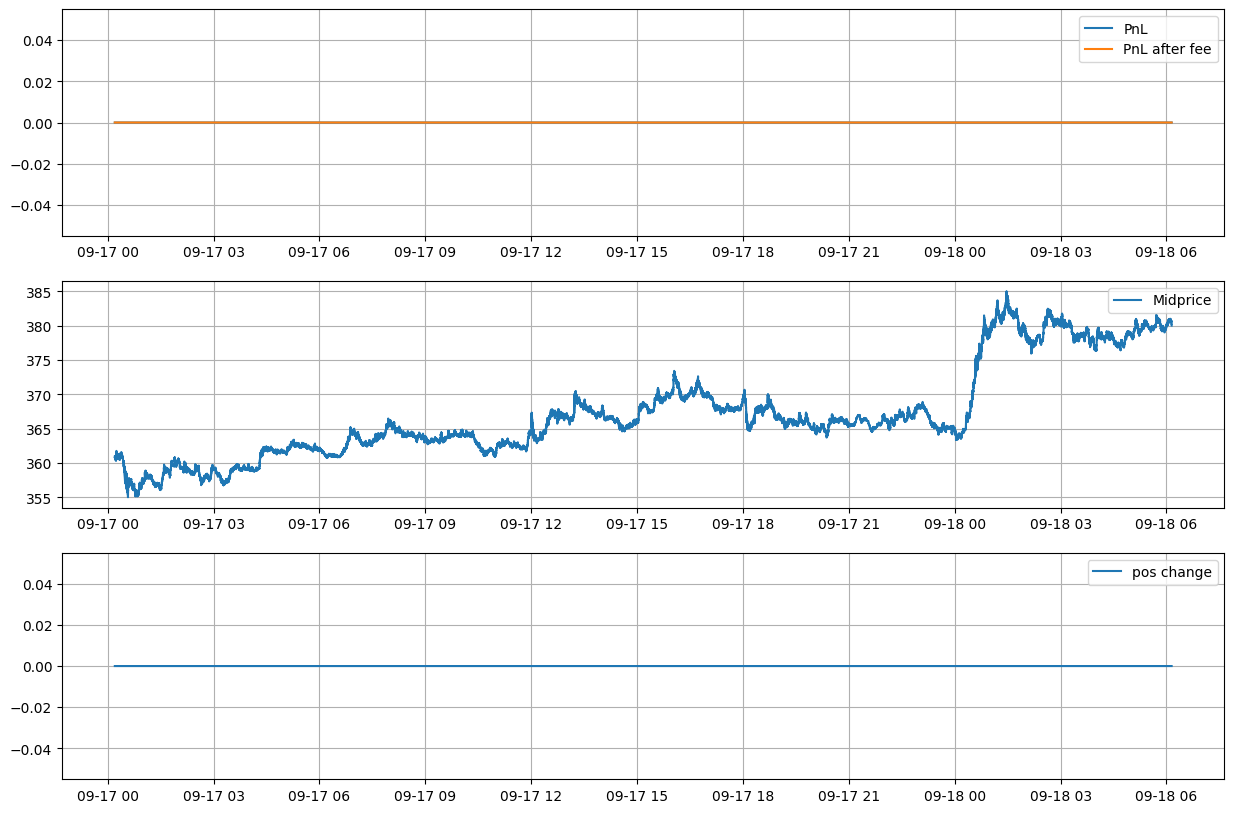

In [113]:
summary, result = backtest(backtest_df, strategy_trading_1, strategy_params, viz=True)

Бэктест возвращает результат работы стратегии.  
```summary``` содержит итоговую информацию:
- pnl : Profits and Losses (PnL, P&L) - сумма всех доходов и убытков по закрытым позициям. 
- **pnl_after_fee : Pnl после комиссии. За каждую сделку биржа берёт комиссию. В данном случае она составляет 0.0001 от цены актива в момент совершения сделки. Это ключевой показатель при анализе эффективности стратегии.**  
- actions : Количество сделок, совершенное стратегией  

Выводы по этой стратегии:  
Она слишком чувствительна к сигналу, поэтому совершает большое количество сделок, из которых почти все убыточны. 

```result``` - исходный датафрейм, к которому добавлены данные по стратегии в каждый момент времени. Может использоваться для детального анализа работы стратегии

### Задачa
Написать свою торговую стратегию, которая будет опираться на сигнал модели для принятия решения.  
#### Ограничения: 
- Максимальная позиция не должна превышать 1
- Нельзя самостоятельно вносить изменения в бэктест
- Стратегия должна содержать текстовое описание  

#### Критерии оценки стратегии:
- Pnl после комиссии 
- Количество сделок > 50